In [1]:
import torch
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def prepare_data(df):
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col] * df['AdjustmentFactor']
    
    df.ExpectedDividend.fillna(0, inplace=True)
    df.drop(['AdjustmentFactor', 'RowId'], axis=1, inplace=True)
    df['SupervisionFlag'] = df['SupervisionFlag'].astype(int)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    
    
    df.sort_values(by=['SecuritiesCode','Date'], inplace=True)
    df['Open'].interpolate(inplace=True)
    df['High'].interpolate(inplace=True)
    df['Low'].interpolate(inplace=True)
    df['Close'].interpolate(inplace=True)
    df.loc[df['Volume'] == 0,"Volume"] = np.nan
    df['Volume'].interpolate(inplace=True)
    df['Target'].interpolate(inplace=True)
    
    return df

In [18]:
def create_diffs(df):
    d1 = lambda df,col: df[col].diff(periods=1)/(df[col] + 1e-8)

    for f in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df['diff' + f] = d1(df, f)
    df['pctDailyChange'] = (df['Close'] - df['Open'])/df['Close']
    df = df.dropna()
    return df

In [19]:
t = pd.read_csv("../jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv",
                parse_dates=["Date"])

In [20]:
t = prepare_data(t)

In [24]:
features = ['diffOpen', 'diffHigh', 'diffLow', 'diffClose', 'diffVolume', 'pctDailyChange', 'ExpectedDividend', ] 
target = 'Target'
stock = t.loc[t['SecuritiesCode'] == 1376].reset_index(drop=True).copy()
stock = create_diffs(stock)
train_df = stock.loc[stock.Date < t.Date.unique()[-100], [*features, target]]
test_df = stock.loc[stock.Date >= t.Date.unique()[-100], [*features, target]]
X_train = train_df[features].to_numpy(dtype=float)
y_train = train_df[target].to_numpy(dtype=float)
X_test = test_df[features].to_numpy(dtype=float)
y_test = test_df[target].to_numpy(dtype=float)

In [25]:
class Dataset(torch.utils.data.Dataset):
    # load the dataset
    def __init__(self, X, y):
        # store the inputs and outputs
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [26]:
batchSize = 1
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)

In [27]:
class ElmanRNN(torch.nn.Module):
    def __init__(self, n_inputs):
        super(ElmanRNN, self).__init__()
        self.hidden_size = 100
        self.W_x = Linear(n_inputs, self.hidden_size)
        self.W_h = Linear(self.hidden_size, self.hidden_size)
        self.W_o = Linear(self.hidden_size, 1)
        self.activation = LeakyReLU()
 
    def forward(self, X, h):
        X = self.W_x(X)
        h = self.W_h(h)
        h = self.activation(X + h)
        X = self.W_o(h)
        return X, h
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [28]:
model = ElmanRNN(len(features)).to(device)
h = model.init_hidden().to(device)

In [29]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, min_lr=1e-8, factor=0.5)

In [30]:
start_time = datetime.now()

for epoch in range(60):
    train_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat, h = model(inputs, h)
        loss = criterion(yhat, targets)
        loss.backward(retain_graph=True)
        optimizer.step()
        h = h.detach()
        train_loss += loss
        
    model.eval()
    
    with torch.no_grad():
        eval_loss = 0
        y_pred = []
        for i, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            yhat, h = model(inputs, h)
            loss = criterion(yhat, targets)
            eval_loss += loss
            y_pred.append(yhat.item())
        
    scheduler.step(eval_loss)
    
    if epoch % 1 == 0:
        print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(test_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.0301, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0173, device='cuda:0')
Epoch: 1, train loss: tensor(0.0198, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0133, device='cuda:0')
Epoch: 2, train loss: tensor(0.0165, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0155, device='cuda:0')
Epoch: 3, train loss: tensor(0.0154, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0123, device='cuda:0')
Epoch: 4, train loss: tensor(0.0142, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0125, device='cuda:0')
Epoch: 5, train loss: tensor(0.0138, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0113, device='cuda:0')
Epoch: 6, train loss: tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0113, device='cuda:0')
Epoch: 7, train loss: tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0103, device='cuda:0')
Epoch: 8, train loss: te

KeyboardInterrupt: 

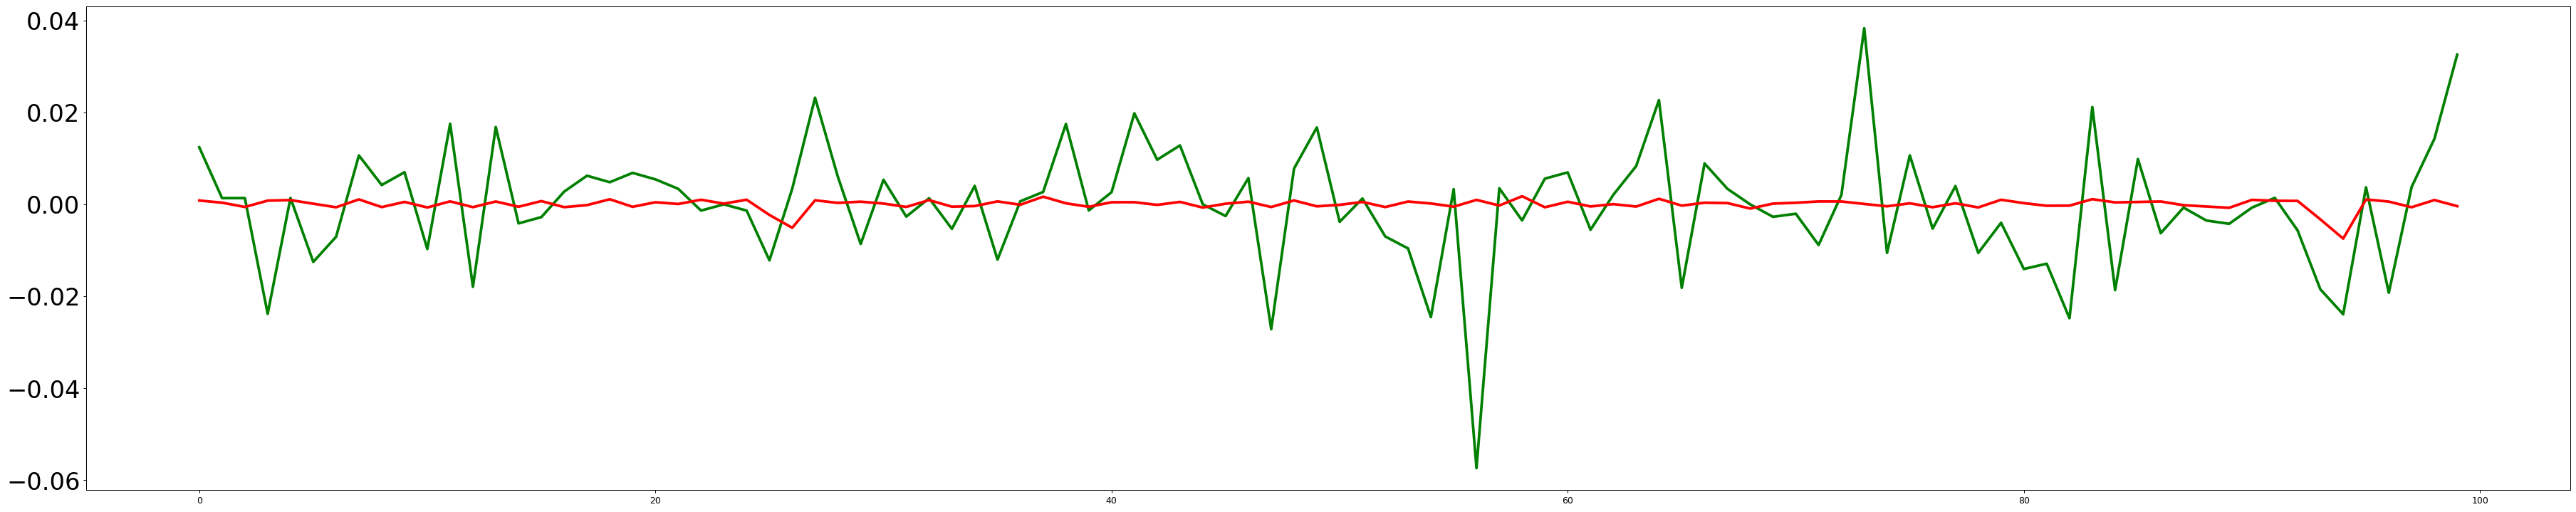

In [31]:
fig1, ax1 = plt.subplots(figsize=(50, 10), dpi=90)
ax1.tick_params(axis='y', which='both',    
                labeltop='on', labelbottom='off', labelsize=27)
ax1.plot(y_test, 'g', lw=3)
ax1.plot(y_pred,'r', lw=3)

In [ ]:
a = torch.Tensor(y_test)
b = torch.Tensor([-0.0003]*len(y_test))
criterion(a, b)

In [ ]:
y_test.mean()